In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from skimage.transform import resize
import time

### Load and plot data example

In [20]:
ds = xr.open_zarr("https://swift.dkrz.de/v1/dkrz_948e7d4bbfbb445fbff5315fc433e36a/GOES16-ABI/GOES16_C13_1024N_6140E_EUREC4A.zarr")
ds

<xarray.Dataset>
Dimensions:  (time: 2871, lat: 2310, lon: 1540)
Coordinates:
  * lat      (lat) float64 24.0 23.99 23.98 23.98 ... 10.02 10.02 10.01 10.0
  * lon      (lon) float64 -60.99 -60.98 -60.97 -60.95 ... -40.03 -40.02 -40.01
  * time     (time) datetime64[ns] 2020-01-01T00:00:21.600000 ... 2020-02-29T...
Data variables:
    C13      (time, lat, lon) float64 dask.array<chunksize=(1, 2310, 1540), meta=np.ndarray>
Attributes:
    Conventions:     CF-1.7
    converted_by:    Hauke Schulz (hauke.schulz@mpimet.mpg.de)
    created_with:    download_GOES16.py with its last modification on Mon Feb...
    creation_date:   Tue Mar  9 19:37:21 2021
    description:     GOES16 satellite data regridded on a regular grid
    institution:     Max Planck Institute for Meteorology, Hamburg, Germany
    python_version:  3.7.6 | packaged by conda-forge | (default, Mar  5 2020,...
    source:          gcp-public-data-goes-16/ABI-L1b-RadF/2020/001/00/OR_ABI-...
    title:           Geostationary satellite imagery from GOES16 on regular grid
    version:         --

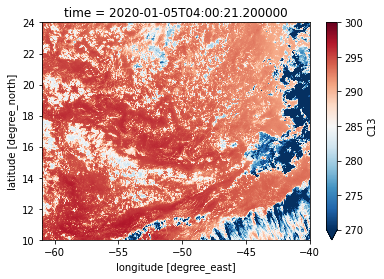

In [21]:
# Using Hauke's colour schemes
vmin = 270
vmax = 300
cmap = "RdBu_r"

test_scene = ds.C13.isel(time=200)
test_scene.plot(cmap=cmap, vmin=vmin, vmax=vmax)

### Define area subset and cloud mask following [Schulz et al. (2022)](https://doi.org/10.5194/essd-14-1233-2022).
- Longitude $\in$ [58-48] W, latitude $\in$ [10-20] N.
- Recast to equidistant grid, since ``cloudmetrics`` assumes ``dx=dy=constant``
- Cloudy pixels are C13 $\in$ [280-290] K
- Reject if 25<sup>th</sup> percentile of C13 < 285 (high clouds)

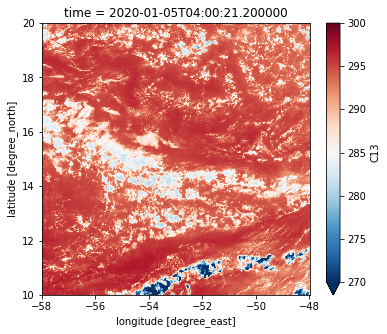

In [4]:
# Subset original image
lat0, lat1, lon0, lon1 = [10, 20, -58, -47.99] # Bodge to make latitude even number of points
T_high_min = 285

test_sub = test_scene.sel(lat=slice(lat1, lat0), lon=slice(lon0,lon1))
plt.figure(figsize=(6,5))
test_sub.plot(cmap=cmap, vmin=vmin, vmax=vmax)

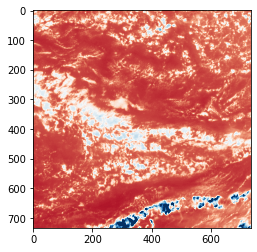

In [5]:
# Resize to square where dlat=dlon (with anti-aliasing). Don't know if this is wildly inappropriate.
imin = np.argmin(test_sub.shape)
test_sub_res = resize(test_sub, (test_sub.shape[imin],test_sub.shape[imin]), anti_aliasing=True)
plt.imshow(test_sub_res, cmap=cmap, vmin=vmin, vmax=vmax)

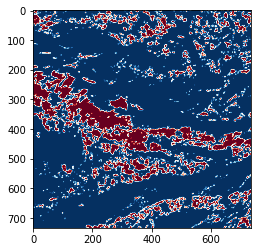

In [6]:
# Cloud mask
T_cl_min = 280
T_cl_max = 290

test_cm = np.zeros(test_sub_res.shape,dtype=int)
test_cm[(test_sub_res < T_cl_max) & (test_sub_res > T_cl_min)] = 1
plt.imshow(test_cm, cmap=cmap)

In [7]:
# Test high clouds
q_cutoff = 25
T_cutoff = 285

# Can use either brightness temperature of cloudy pixels, or all pixels.
# Reading from his manuscript, it seems Hauke uses the latter.
# T_q = np.percentile(test_sub_res[test_cm == 1], q_cutoff)
T_q = np.percentile(test_sub_res, q_cutoff)

print('25th percentile T:', T_q)
if T_q < T_cutoff:
    print('Reject due to high clouds')

25th percentile T: 291.334452228821


### Test a few metrics

In [8]:
import cloudmetrics

# Cloud mask metrics
print('cf   : ',cloudmetrics.mask.cloud_fraction(test_cm))
print('frac : ',cloudmetrics.mask.fractal_dimension(test_cm))
# print('open sky:', cloudmetrics.mask.open_sky(test_cm))

# Object metrics
# Could do this using cloud mask directly...
# print('iorg : ',cloudmetrics.mask.iorg_objects(test_cm, periodic_domain=False))
# print('scai : ',cloudmetrics.mask.scai_objects(test_cm, periodic_domain=False))
# print('cop  : ',cloudmetrics.mask.cop_objects(test_cm, periodic_domain=False))

# ...or using object labels explicitly (would need to make the mask periodic first yourself if periodic bcs)
object_labels = cloudmetrics.objects.label(test_cm)
print('iorg : ',cloudmetrics.objects.iorg(object_labels))
print('scai : ',cloudmetrics.objects.scai(object_labels))
print('cop  : ',cloudmetrics.objects.cop(object_labels))
print('max len  : ',cloudmetrics.objects.max_length_scale(object_labels))
print('mean len  : ',cloudmetrics.objects.mean_length_scale(object_labels))
print('mean ecc  : ',cloudmetrics.objects.mean_eccentricity(object_labels))
print('mean peri  : ',cloudmetrics.objects.mean_perimeter_length(object_labels))

# Scalar metrics
print('spectral : ',cloudmetrics.scalar.compute_all_spectral(test_sub_res))
print('woi1 :',cloudmetrics.scalar.woi1(test_sub_res))
print('woi2 :',cloudmetrics.scalar.woi2(test_sub_res))
print('woi3 :',cloudmetrics.scalar.woi3(test_sub_res))
print('mean :',cloudmetrics.scalar.mean(test_sub_res))
print('var :',cloudmetrics.scalar.var(test_sub_res))
# print('skew :',cloudmetrics.scalar.skew(test_sub_res)) # FIXME need to tell scipy.stats.skew to go None, not along 0 azis
# print('kurt :',cloudmetrics.scalar.kurtosis(test_sub_res)) # FIXME need to tell scipy.stats.skew to go None, not along 0 azis

# Alternative (explicit) computation of spectral metrics
# wavenumbers, psd_1d_radial, psd_1d_azimuthal = cloudmetrics.scalar.compute_spectra(test_sub_res)
# print('spec. len. mom. :', cloudmetrics.scalar.spectral_length_moment(wavenumbers, psd_1d_radial))


cf   :  0.184280082263585
frac :  1.6511023768766708
iorg :  0.6181480612976324
scai :  1.7762731753536443
cop  :  0.01866468867679452
max len  :  196.95684806576287
mean len  :  8.445310880131588
mean ecc  :  0.8945377009027107
mean peri  :  25.986049703388755
spectral :  (0.8994960581634415, -0.7778260403850719, -1.0188161275991174, 122.33333333333331, 30.013483353727796)
woi1 : 0.4695693814023009
woi2 : 1.1538600729421894e-05
woi3 : 0.37586488140963287
mean : 292.50199411221325
var : 18.0375944717884


## Compute and store `cloudmetrics` for all scenes

In [15]:
import inspect

metrics = [
           'cloud_fraction',
           'fractal_dimension',
           'open_sky',
           'cop',
           'iorg',
           'scai',
           'max_length_scale',
           'mean_eccentricity',
           'mean_length_scale',
           'mean_perimeter_length',
           'num_objects',
           'orientation',
           'spectral_length_moment',
           'spectral_anisotropy',
           'spectral_slope',
           'woi1',
           'woi2',
           'woi3',
           'mean',
           'var',
          ]

# These are the metrics you can choose from
available_mask_metrics = dict(inspect.getmembers(cloudmetrics.mask, inspect.isfunction))
available_object_metrics = dict(inspect.getmembers(cloudmetrics.objects, inspect.isfunction))
available_scalar_metrics = dict(inspect.getmembers(cloudmetrics.scalar, inspect.isfunction))

In [10]:
load_df = True

if load_df:
    df_metrics = pd.read_hdf('df_metrics.h5')
else:
    df_metrics = pd.DataFrame(index=ds['time'], columns=metrics)

### Main loop, using variable definitions from earlier cells
**ONLY RUN IF YOU WANT TO REPLACE METRICS. THIS MAY TAKE A FEW HOURS**

In [12]:
for i in range(1600,len(ds['time'])):
    print('Processing ', ds['time'][i].data, 'scene ', i+1, '/', len(ds['time']))
    
    # These operations will try to actually access the data, but network access to data source 
    # is unstable so need to build in fail-safe
    while True:
        # Select
        scene = ds.C13.isel(time=i)

        # Subset
        scene = scene.sel(lat=slice(lat1, lat0), lon=slice(lon0,lon1))

        try:
            # Resize
            imin = np.argmin(scene.shape)
            scene = resize(scene, (scene.shape[imin],scene.shape[imin]), anti_aliasing=True)
            assert(np.isnan(scene).any() == False)
        except:
            print('Unable to access scene, retrying...')
            time.sleep(5)
            continue
        break
    
    # Plot scene
#     plt.imshow(scene, cmap=cmap, vmin=vmin, vmax=vmax)
#     plt.show()
    
    # Define cloud mask
    cloud_mask = np.zeros(scene.shape,dtype=int)
    cloud_mask[(scene < T_cl_max) & (scene > T_cl_min)] = 1
    
    # Test high clouds
    if np.percentile(test_sub_res, q_cutoff) < T_cutoff:
        print('Reject due to high clouds')
        continue
    
    # Compute selected metrics
    computed_object_labels = False
    computed_spectra = False
    for j in range(len(metrics)):
        # Cloud object metrics
        if metrics[j] in available_object_metrics.keys():
#             print('Computing', metrics[j])
            
            # Compute object labels if not done yet
            if not computed_object_labels:
                object_labels = cloudmetrics.objects.label(cloud_mask)
                computed_object_labels = True
            
            # Compute metric
            fn_metric = available_object_metrics[metrics[j]]
            df_metrics.iloc[i, df_metrics.columns.get_loc(metrics[j])] = fn_metric(object_labels)
        
        # Cloud mask metrics
        elif metrics[j] in available_mask_metrics.keys():
#             print('Computing', metrics[j])
            fn_metric = available_mask_metrics[metrics[j]]
            
            # Open sky exception - just take the mean open sky area (second function output)
            if 'open_sky' in metrics[j]:
                _, df_metrics.iloc[i, df_metrics.columns.get_loc(metrics[j])] = fn_metric(cloud_mask)
            else:
                df_metrics.iloc[i, df_metrics.columns.get_loc(metrics[j])] = fn_metric(cloud_mask)

        # Cloud scalar metrics
        elif metrics[j] in available_scalar_metrics.keys():
#             print('Computing', metrics[j])
            fn_metric = available_scalar_metrics[metrics[j]]
            
            # Spectral metrics exception
            if 'spectral' in metrics[j]:
                
                # Compute spectra if not done yet
                if not computed_spectra:
                    wavenumbers, psd_1d_radial, psd_1d_azimuthal = cloudmetrics.scalar.compute_spectra(scene)
                    computed_spectra = True
                
                # Compute metrics
                if 'anisotropy' in metrics[j]:
                    df_metrics.iloc[i, df_metrics.columns.get_loc(metrics[j])] = fn_metric(psd_1d_azimuthal)
                else:
                    df_metrics.iloc[i, df_metrics.columns.get_loc(metrics[j])] = fn_metric(wavenumbers, psd_1d_radial)
            
            # All other scalar metrics computed normally
            else:
                df_metrics.iloc[i, df_metrics.columns.get_loc(metrics[j])] = fn_metric(scene)
        # Store after each scene
        df_metrics.to_hdf('df_metrics.h5', 'cloudmetrics', mode='w')
df_metrics

Processing  2020-02-03T11:00:12.200000000 scene  1601 / 2871


/home/WUR/janss254/my_envs/c3ontext/lib/python3.7/site-packages/pandas/core/generic.py:2718: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer-float,key->block0_values] [items->Index(['cloud_fraction', 'fractal_dimension', 'open_sky', 'cop', 'iorg',
       'scai', 'max_length_scale', 'mean_eccentricity', 'mean_length_scale',
       'mean_perimeter_length', 'num_objects', 'orientation',
       'spectral_length_moment', 'spectral_anisotropy', 'spectral_slope',
       'woi1', 'woi2', 'woi3'],
      dtype='object')]

  encoding=encoding,


Processing  2020-02-03T11:30:12.200000000 scene  1602 / 2871
Processing  2020-02-03T12:00:12.200000000 scene  1603 / 2871
Processing  2020-02-03T12:30:12.100000000 scene  1604 / 2871
Processing  2020-02-03T13:00:12.100000000 scene  1605 / 2871
Processing  2020-02-03T13:30:12.100000000 scene  1606 / 2871
Processing  2020-02-03T14:00:12.100000000 scene  1607 / 2871
Processing  2020-02-03T14:30:12.000000000 scene  1608 / 2871
Processing  2020-02-03T15:00:12.000000000 scene  1609 / 2871
Processing  2020-02-03T15:30:12.000000000 scene  1610 / 2871
Processing  2020-02-03T16:00:12.000000000 scene  1611 / 2871
Processing  2020-02-03T16:30:11.900000000 scene  1612 / 2871
Processing  2020-02-03T17:00:11.900000000 scene  1613 / 2871
Processing  2020-02-03T17:30:11.700000000 scene  1614 / 2871
Processing  2020-02-03T18:00:11.600000000 scene  1615 / 2871
Processing  2020-02-03T18:30:11.600000000 scene  1616 / 2871
Processing  2020-02-03T19:00:11.600000000 scene  1617 / 2871
Processing  2020-02-03T1

Processing  2020-02-06T07:00:10.400000000 scene  1737 / 2871
Processing  2020-02-06T07:30:10.400000000 scene  1738 / 2871
Processing  2020-02-06T08:00:10.400000000 scene  1739 / 2871
Processing  2020-02-06T08:30:10.400000000 scene  1740 / 2871
Processing  2020-02-06T09:00:10.400000000 scene  1741 / 2871
Processing  2020-02-06T09:30:10.400000000 scene  1742 / 2871
Processing  2020-02-06T10:00:10.400000000 scene  1743 / 2871
Processing  2020-02-06T10:30:10.400000000 scene  1744 / 2871
Processing  2020-02-06T11:00:10.400000000 scene  1745 / 2871
Processing  2020-02-06T11:30:10.400000000 scene  1746 / 2871
Processing  2020-02-06T12:00:10.400000000 scene  1747 / 2871
Processing  2020-02-06T12:30:10.400000000 scene  1748 / 2871
Processing  2020-02-06T13:00:10.400000000 scene  1749 / 2871
Processing  2020-02-06T13:30:10.400000000 scene  1750 / 2871
Processing  2020-02-06T14:00:10.400000000 scene  1751 / 2871
Processing  2020-02-06T14:30:10.300000000 scene  1752 / 2871
Processing  2020-02-06T1

Processing  2020-02-09T02:30:08.000000000 scene  1872 / 2871
Processing  2020-02-09T03:00:08.000000000 scene  1873 / 2871
Processing  2020-02-09T03:30:08.000000000 scene  1874 / 2871
Processing  2020-02-09T04:00:08.000000000 scene  1875 / 2871
Processing  2020-02-09T04:30:07.900000000 scene  1876 / 2871
Processing  2020-02-09T05:00:07.900000000 scene  1877 / 2871
Processing  2020-02-09T05:30:08.100000000 scene  1878 / 2871
Processing  2020-02-09T06:00:08.100000000 scene  1879 / 2871
Processing  2020-02-09T06:30:08.100000000 scene  1880 / 2871
Processing  2020-02-09T07:00:08.000000000 scene  1881 / 2871
Processing  2020-02-09T07:30:08.000000000 scene  1882 / 2871
Processing  2020-02-09T08:00:08.000000000 scene  1883 / 2871
Processing  2020-02-09T08:30:08.000000000 scene  1884 / 2871
Processing  2020-02-09T09:00:07.900000000 scene  1885 / 2871
Processing  2020-02-09T09:30:07.900000000 scene  1886 / 2871
Processing  2020-02-09T10:00:07.900000000 scene  1887 / 2871
Processing  2020-02-09T1

Processing  2020-02-11T22:30:04.600000000 scene  2007 / 2871
Processing  2020-02-11T23:00:04.500000000 scene  2008 / 2871
Processing  2020-02-11T23:30:04.500000000 scene  2009 / 2871
Processing  2020-02-12T00:00:04.500000000 scene  2010 / 2871
Processing  2020-02-12T00:30:04.500000000 scene  2011 / 2871
Processing  2020-02-12T01:00:04.400000000 scene  2012 / 2871
Processing  2020-02-12T01:30:04.400000000 scene  2013 / 2871
Processing  2020-02-12T02:00:04.400000000 scene  2014 / 2871
Processing  2020-02-12T02:30:04.400000000 scene  2015 / 2871
Processing  2020-02-12T03:00:04.300000000 scene  2016 / 2871
Processing  2020-02-12T03:30:04.300000000 scene  2017 / 2871
Processing  2020-02-12T04:00:04.300000000 scene  2018 / 2871
Processing  2020-02-12T04:30:04.300000000 scene  2019 / 2871
Processing  2020-02-12T05:00:04.200000000 scene  2020 / 2871
Processing  2020-02-12T05:30:04.400000000 scene  2021 / 2871
Processing  2020-02-12T06:00:04.400000000 scene  2022 / 2871
Processing  2020-02-12T0

Processing  2020-02-14T18:00:01.700000000 scene  2142 / 2871
Processing  2020-02-14T18:30:01.700000000 scene  2143 / 2871
Processing  2020-02-14T19:00:01.700000000 scene  2144 / 2871
Processing  2020-02-14T19:30:01.600000000 scene  2145 / 2871
Processing  2020-02-14T20:00:01.600000000 scene  2146 / 2871
Processing  2020-02-14T20:30:01.600000000 scene  2147 / 2871
Processing  2020-02-14T21:00:01.600000000 scene  2148 / 2871
Processing  2020-02-14T21:30:01.500000000 scene  2149 / 2871
Processing  2020-02-14T22:00:01.500000000 scene  2150 / 2871
Processing  2020-02-14T22:30:01.500000000 scene  2151 / 2871
Processing  2020-02-14T23:00:01.500000000 scene  2152 / 2871
Processing  2020-02-14T23:30:01.500000000 scene  2153 / 2871
Processing  2020-02-15T00:00:01.500000000 scene  2154 / 2871
Processing  2020-02-15T00:30:01.500000000 scene  2155 / 2871
Processing  2020-02-15T01:00:01.400000000 scene  2156 / 2871
Processing  2020-02-15T01:30:01.400000000 scene  2157 / 2871
Processing  2020-02-15T0

Processing  2020-02-17T13:30:20.100000000 scene  2277 / 2871
Processing  2020-02-17T14:00:20.100000000 scene  2278 / 2871
Processing  2020-02-17T14:30:20.100000000 scene  2279 / 2871
Processing  2020-02-17T15:00:20.100000000 scene  2280 / 2871
Processing  2020-02-17T15:30:20.100000000 scene  2281 / 2871
Processing  2020-02-17T16:00:20.100000000 scene  2282 / 2871
Processing  2020-02-17T16:30:20.100000000 scene  2283 / 2871
Processing  2020-02-17T17:00:20.100000000 scene  2284 / 2871
Processing  2020-02-17T17:30:19.900000000 scene  2285 / 2871
Processing  2020-02-17T18:00:19.900000000 scene  2286 / 2871
Processing  2020-02-17T18:30:19.900000000 scene  2287 / 2871
Processing  2020-02-17T19:00:19.900000000 scene  2288 / 2871
Processing  2020-02-17T19:30:19.900000000 scene  2289 / 2871
Processing  2020-02-17T20:00:19.900000000 scene  2290 / 2871
Processing  2020-02-17T20:30:19.800000000 scene  2291 / 2871
Processing  2020-02-17T21:00:19.800000000 scene  2292 / 2871
Processing  2020-02-17T2

Processing  2020-02-20T09:30:19.500000000 scene  2412 / 2871
Processing  2020-02-20T10:00:19.500000000 scene  2413 / 2871
Processing  2020-02-20T10:30:19.400000000 scene  2414 / 2871
Processing  2020-02-20T11:00:19.400000000 scene  2415 / 2871
Processing  2020-02-20T11:30:19.400000000 scene  2416 / 2871
Processing  2020-02-20T12:00:19.400000000 scene  2417 / 2871
Processing  2020-02-20T12:30:19.400000000 scene  2418 / 2871
Processing  2020-02-20T13:00:19.400000000 scene  2419 / 2871
Processing  2020-02-20T13:30:19.400000000 scene  2420 / 2871
Processing  2020-02-20T14:00:19.400000000 scene  2421 / 2871
Processing  2020-02-20T14:30:19.400000000 scene  2422 / 2871
Processing  2020-02-20T15:00:19.400000000 scene  2423 / 2871
Processing  2020-02-20T15:30:19.400000000 scene  2424 / 2871
Processing  2020-02-20T16:00:19.400000000 scene  2425 / 2871
Processing  2020-02-20T16:30:19.400000000 scene  2426 / 2871
Processing  2020-02-20T17:00:19.400000000 scene  2427 / 2871
Processing  2020-02-20T1

Processing  2020-02-23T05:00:18.800000000 scene  2547 / 2871
Processing  2020-02-23T05:30:19.000000000 scene  2548 / 2871
Processing  2020-02-23T06:00:19.000000000 scene  2549 / 2871
Processing  2020-02-23T06:30:19.100000000 scene  2550 / 2871
Processing  2020-02-23T07:00:19.100000000 scene  2551 / 2871
Processing  2020-02-23T07:30:19.100000000 scene  2552 / 2871
Processing  2020-02-23T08:00:19.100000000 scene  2553 / 2871
Processing  2020-02-23T08:30:19.100000000 scene  2554 / 2871
Processing  2020-02-23T09:00:19.100000000 scene  2555 / 2871
Processing  2020-02-23T09:30:19.100000000 scene  2556 / 2871
Processing  2020-02-23T10:00:19.100000000 scene  2557 / 2871
Processing  2020-02-23T10:30:19.100000000 scene  2558 / 2871
Processing  2020-02-23T11:00:19.100000000 scene  2559 / 2871
Processing  2020-02-23T11:30:19.100000000 scene  2560 / 2871
Processing  2020-02-23T12:00:19.200000000 scene  2561 / 2871
Processing  2020-02-23T12:30:19.200000000 scene  2562 / 2871
Processing  2020-02-23T1

Processing  2020-02-26T01:00:18.400000000 scene  2682 / 2871
Processing  2020-02-26T01:30:18.400000000 scene  2683 / 2871
Processing  2020-02-26T02:00:18.400000000 scene  2684 / 2871
Processing  2020-02-26T02:30:18.400000000 scene  2685 / 2871
Processing  2020-02-26T03:00:18.400000000 scene  2686 / 2871
Processing  2020-02-26T03:30:18.400000000 scene  2687 / 2871
Processing  2020-02-26T04:00:18.400000000 scene  2688 / 2871
Processing  2020-02-26T04:30:18.400000000 scene  2689 / 2871
Processing  2020-02-26T05:00:18.400000000 scene  2690 / 2871
Processing  2020-02-26T05:30:18.600000000 scene  2691 / 2871
Processing  2020-02-26T06:00:18.600000000 scene  2692 / 2871
Processing  2020-02-26T06:30:18.600000000 scene  2693 / 2871
Processing  2020-02-26T07:00:18.600000000 scene  2694 / 2871
Processing  2020-02-26T07:30:18.600000000 scene  2695 / 2871
Processing  2020-02-26T08:00:18.600000000 scene  2696 / 2871
Processing  2020-02-26T08:30:18.600000000 scene  2697 / 2871
Processing  2020-02-26T0

Processing  2020-02-28T20:30:17.600000000 scene  2817 / 2871
Processing  2020-02-28T21:00:17.600000000 scene  2818 / 2871
Processing  2020-02-28T21:30:17.600000000 scene  2819 / 2871
Processing  2020-02-28T22:00:17.600000000 scene  2820 / 2871
Processing  2020-02-28T22:30:17.600000000 scene  2821 / 2871
Processing  2020-02-28T23:00:17.600000000 scene  2822 / 2871
Processing  2020-02-28T23:30:17.600000000 scene  2823 / 2871
Processing  2020-02-29T00:00:17.600000000 scene  2824 / 2871
Processing  2020-02-29T00:30:17.600000000 scene  2825 / 2871
Processing  2020-02-29T01:00:17.600000000 scene  2826 / 2871
Processing  2020-02-29T01:30:17.600000000 scene  2827 / 2871
Processing  2020-02-29T02:00:17.600000000 scene  2828 / 2871
Processing  2020-02-29T02:30:17.600000000 scene  2829 / 2871
Processing  2020-02-29T03:00:17.600000000 scene  2830 / 2871
Processing  2020-02-29T03:30:17.500000000 scene  2831 / 2871
Processing  2020-02-29T04:00:17.500000000 scene  2832 / 2871
Processing  2020-02-29T0

,cloud_fraction,fractal_dimension,open_sky,cop,iorg,scai,max_length_scale,mean_eccentricity,mean_length_scale,mean_perimeter_length,num_objects,orientation,spectral_length_moment,spectral_anisotropy,spectral_slope,woi1,woi2,woi3,mean,var
2020-01-01 00:00:21.600,0.234394,1.625783,0.112289,0.018923,0.675079,0.89221,252.360853,0.866068,12.848082,46.296075,765,0.85142,44.168514,0.979504,-1.214628,0.674764,0.000038,0.524303,291.006199,50.126598
2020-01-01 00:30:21.600,0.223914,1.624268,0.094072,0.018993,0.682575,0.965198,250.597286,0.80842,11.991008,41.181486,839,0.843672,44.616633,0.980634,-1.124539,0.682998,0.000048,0.50221,290.954331,58.417196
2020-01-01 01:00:21.600,0.212267,1.618992,0.082388,0.01985,0.676728,1.054974,226.881026,0.79688,11.095049,36.263611,929,0.835232,49.442421,0.980956,-1.095677,0.710041,0.000061,0.482315,290.788811,69.077764
2020-01-01 01:30:21.600,0.206609,1.612443,0.083441,0.020167,0.65221,0.990473,245.0959,0.791959,11.350477,37.317085,864,0.831739,53.514946,0.979051,-1.102114,0.721252,0.000073,0.466083,290.609852,80.182871
2020-01-01 02:00:21.600,0.198747,1.608335,0.091565,0.018493,0.670589,1.057147,236.875495,0.805579,10.999538,35.273979,885,0.813362,57.296696,0.976292,-1.113689,0.735915,0.000074,0.437446,290.674953,80.126756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-29 21:30:17.500,0.184685,1.546062,0.067161,0.021727,0.69569,0.919836,164.292422,0.779369,11.611367,31.210594,738,0.661384,38.53903,0.931657,-0.886599,0.602751,0.000008,0.313101,292.837538,13.080935
2020-02-29 22:00:17.500,0.186197,1.554405,0.065132,0.021605,0.686858,0.954818,202.953197,0.857229,11.297222,30.460562,786,0.673646,36.40745,0.926843,-0.898951,0.586842,0.000008,0.307143,292.802105,12.802521
2020-02-29 22:30:17.500,0.187354,1.569361,0.062497,0.021523,0.671418,0.989594,208.057684,0.849039,11.156216,31.583706,811,0.683276,34.251413,0.934781,-0.902994,0.571741,0.000007,0.310132,292.777178,12.480342
2020-02-29 23:00:17.500,0.187421,1.57646,0.054705,0.02171,0.660929,1.03532,188.589501,0.835473,10.816815,30.155805,863,0.680344,33.324221,0.93403,-0.887673,0.559428,0.000007,0.309498,292.751995,12.411852


## Load, filter, standardise, compute pca

In [16]:
from Postprocess import analysis, utils
from sklearn.decomposition import PCA

# Read from file
df_metrics_pp = pd.read_hdf('df_metrics.h5')

# Filter scenes which miss metrics
nan_filter = metrics
for ind in nan_filter:
    df_metrics_pp = df_metrics_pp[df_metrics_pp[ind].notna()]
# print(df_metrics_pp.isna().any())

# Standardise metrics
data = df_metrics_pp.to_numpy()
data = utils.stand(data)
    
# Compute PCA
pca = PCA()
x_pca = pca.fit_transform(data)

### Standard plots

/home/WUR/janss254/cloudmetrics-c3ontext/Postprocess/utils.py:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


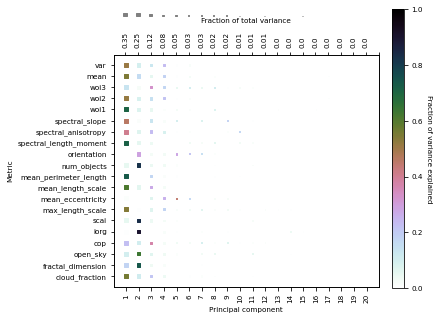

Metric: cloud_fraction Mag:  0.017736121473935253
Metric: fractal_dimension Mag:  0.029999708052530716
Metric: open_sky Mag:  0.027522260448331896
Metric: cop Mag:  0.0006062994378644086
Metric: iorg Mag:  0.016647887645946952
Metric: scai Mag:  0.15074686183139027
Metric: max_length_scale Mag:  16.366107966249505
Metric: mean_eccentricity Mag:  0.0018741741403798975
Metric: mean_length_scale Mag:  0.8247360273603956
Metric: mean_perimeter_length Mag:  2.879299304414079
Metric: num_objects Mag:  124.22139342890647
Metric: orientation Mag:  0.026297297104717662
Metric: spectral_length_moment Mag:  3.746111847855355
Metric: spectral_anisotropy Mag:  0.008069870157540661
Metric: spectral_slope Mag:  0.06663170232748032
Metric: woi1 Mag:  0.03493557004917672
Metric: woi2 Mag:  9.050753539067585e-06
Metric: woi3 Mag:  0.007755407757091629
Metric: mean Mag:  1.0202302769464453
Metric: var Mag:  15.140193657452613
Metric: cloud_fraction Mag:  0.012804538972572745
Metric: fractal_dimension Mag

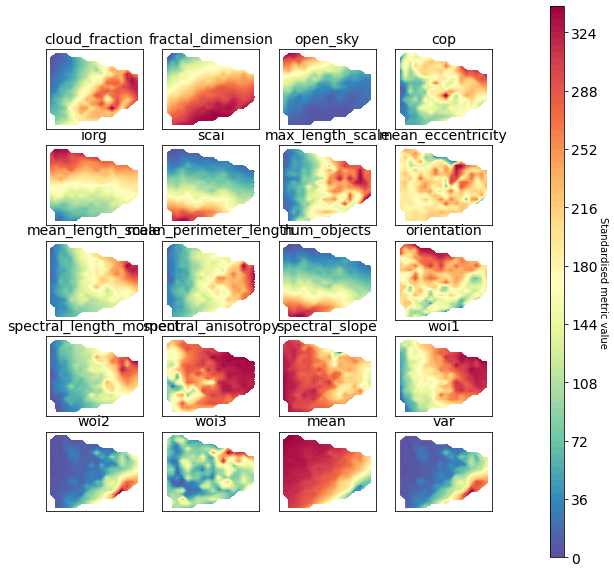

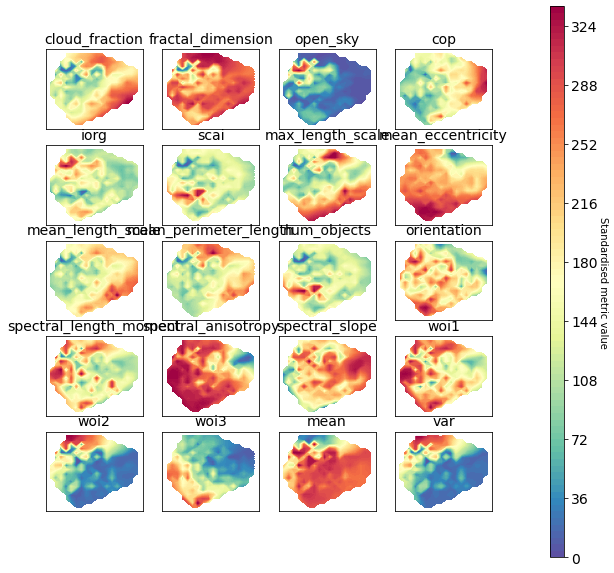

In [17]:
analysis.relateMetricPCA(pca, x_pca, metrics, metrics, './Figures')

axs = utils.plotMetricSurf(x_pca[:,0:2], df_metrics_pp, metrics, metrics,thr=0)
plt.savefig('Figures/interpolation-pc12.pdf',dpi=300,bbox_inches='tight')

axs = utils.plotMetricSurf(x_pca[:,2:4], df_metrics_pp, metrics, metrics,thr=0)
plt.savefig('Figures/interpolation-pc34.pdf',dpi=300,bbox_inches='tight')

At a glance, these are remarkably similar to the correlations I got with MODIS images, which is encouraging. 3 PCs seem necessary to capture the variability in the metrics, and including a fourth one related to the variance across the scene isn't a bad idea.

Now the question is: How do these PCs relate to the identified classes? See compare-C3ONTEXT.